# Projet "Capitals Learning"
## Classification d'images de capitales du monde

Groupe : Paul ANACLET, Nicolas CORMARY, Sylvain CROUZET, Théo DESPRATS

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from models.basic_model_1 import basic_model_1
from models.vgg16_model import vgg16_model
from features.load_data import load_data
from features.get_classes import get_classes
from data.dispatch_data import dispatch_data
from visualization.plot_classes_repartition import plot_classes_repartition
from visualization.plot_training_analysis import plot_training_analysis
from visualization.visualize_random_images import visualize_random_images

### Meta-paramètres

In [2]:
EPOCHS = 50
BATCH_SIZE = 10
LEARNING_RATE = 3e-4
class_labels = ["NY", "Paris", "Tokyo"]

### Meta-fonctions

In [48]:
#Calcule la précision, le rappel, et le F1_score pour chaque classe ainsi que la matrice de confusion
def global_accuracy(y_true, y_pred):
    class_metrics = []
    for i in range(3):
        class_metrics.append({'TP': 0, 'FP': 0, 'FN': 0})

    total_correct_detections = 0
    total_incorrect_detections = 0
    for i in range(len(y_true)):
        # Labels vérité-terrain et prédits        
        groundtruth_label = int(y_true[i])
        predicted_label = np.argmax(y_pred[i])

        # Si la détection est correcte : 
        if groundtruth_label == predicted_label:
            total_correct_detections += 1
            class_metrics[groundtruth_label]['TP'] += 1 
        else:
            total_incorrect_detections += 1
            class_metrics[groundtruth_label]['FN'] += 1 
            class_metrics[predicted_label]['FP'] += 1


    class_res = []
    print("Matrice de confusion")
    for i in range(3):
        TP = class_metrics[i]['TP']
        FN = class_metrics[i]['FN']
        FP = class_metrics[i]['FP']
        print(class_labels[i],":   TP:",TP," FN:",FN, " FP:",FP)

        if TP != 0:
            P = TP / (TP + FP)
            R = TP / (TP + FN)
            F_score = 2 / (1/R + 1/P)
        else:
            P = 0
            R = 0
            F_score = 0
        class_res.append({'Precision': P, 'Rappel': R, 'F-score': F_score})

    accuracy = total_correct_detections / (total_correct_detections + total_incorrect_detections)

    ### FIN
    return class_res, accuracy

In [49]:
def show_prediction(x, y, y_pred=[], id=None, image_size=64):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0]-1)
  else:
    num_img = id

  img = x[num_img]
  lab = int(y[num_img])
  lab_pred = np.argmax(y_pred[num_img])

  # Affichage de l'image
  plt.title("Prédiction: {} - Réel: {}".format(class_labels[lab_pred], class_labels[lab]))
  plt.imshow(img)
  plt.show()

In [51]:
def show_analye(x_test, y_test, model):
    y_pred = model.predict(x_test)

    class_res, accuracy = global_accuracy(y_test, y_pred)

    print(f"La précision globale est de {accuracy:.1f}%")

    print()
    print("------------------------------------------")
    print("| Classe | Précision | Rappel | F1-score |")
    print("------------------------------------------")
    for i in range(3):
        print(f"| {class_labels[i]:7s}|   {class_res[i]['Precision']:.2f}    |  {class_res[i]['Rappel']:.2f}  |   {class_res[i]['F-score']:.2f}   |")
        print("------------------------------------------")
    
    image_idx = [1,18,67,98,145,187,121]

    for i in image_idx:
        show_prediction(x_test, y_test, y_pred = y_pred, id=i, image_size=IMAGE_SIZE)

## Chargement des données

### Répartition des images

In [3]:
# Répartition des images dans les différents datasets
pourcentageTrain = 70
pourcentageTest = 15
pourcentageValidation = 15

dispatch_data(pourcentageTrain, pourcentageTest, pourcentageValidation)


Images successfully dispatched.


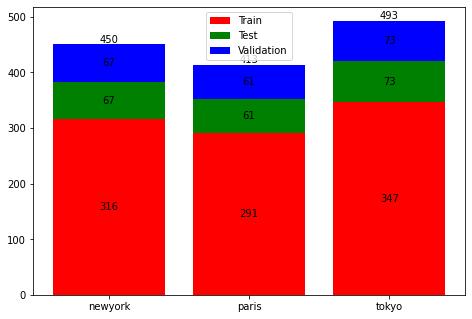

In [4]:
plot_classes_repartition()

### Chargement des images

In [3]:
CLASSES = get_classes()
IMAGE_SIZE = 64

x_train, y_train = load_data(dataset='train', image_size=IMAGE_SIZE)
x_val, y_val = load_data(dataset='validation', image_size=IMAGE_SIZE)
x_test, y_test = load_data(dataset='test', image_size=IMAGE_SIZE)


# Normalisation des entrées via une division par 255 des valeurs de pixel.
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

### Visualisation des images

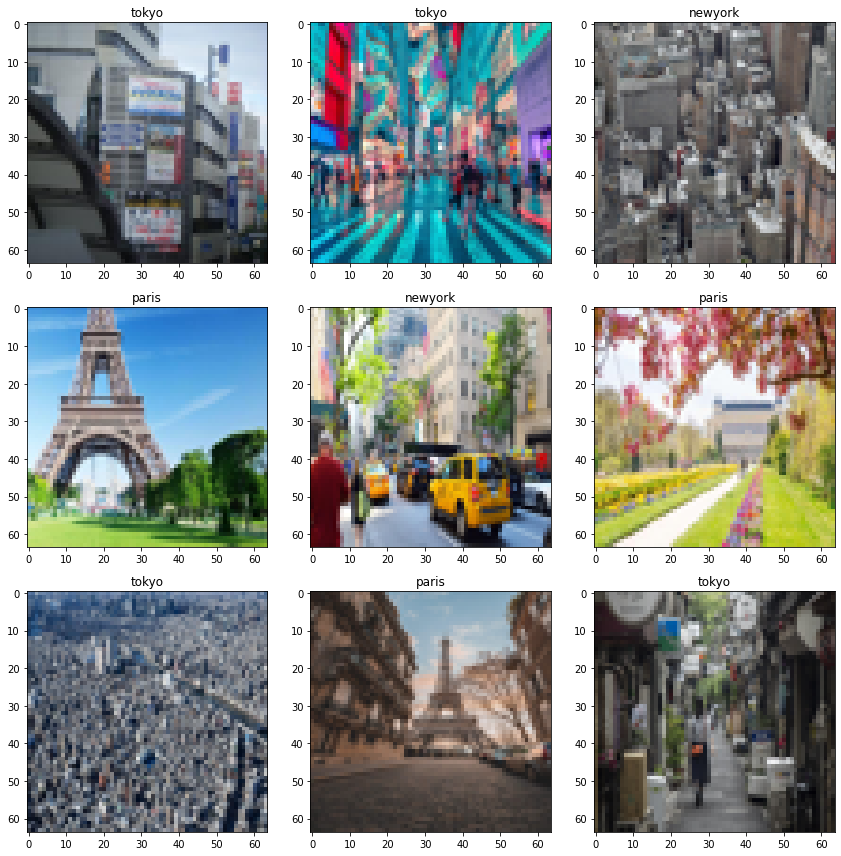

In [4]:
%matplotlib inline

visualize_random_images(x_train, y_train, CLASSES)

### Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

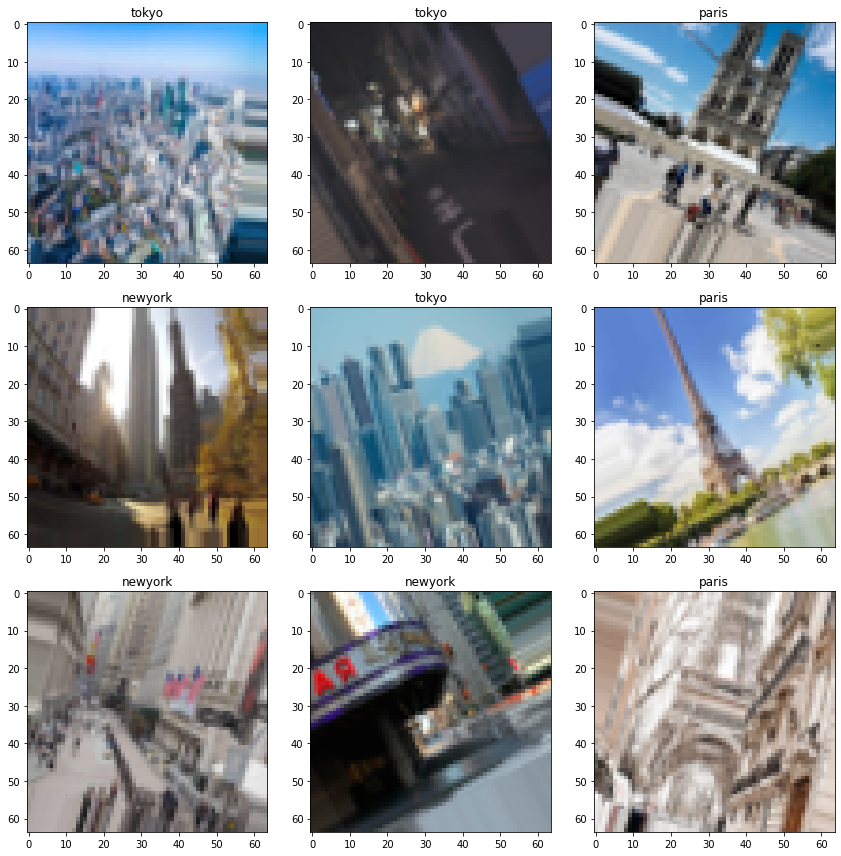

In [5]:
%matplotlib inline

generated = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
img, label = generated.next()

visualize_random_images(img, label, CLASSES)

## Modèles

### Basic Model 1

[Code source](models/basic_model_1.py)

In [52]:
# Creation du modele
model = basic_model_1(CLASSES, IMAGE_SIZE)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 96)        

In [53]:
# Entrainement du modele
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history_bm1 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
96/96 [==============================] - 3s 29ms/step - loss: 1.0942 - accuracy: 0.3553 - val_loss: 1.0576 - val_accuracy: 0.4478
Epoch 2/50
96/96 [==============================] - 3s 29ms/step - loss: 1.0482 - accuracy: 0.4507 - val_loss: 1.0613 - val_accuracy: 0.3980
Epoch 3/50
96/96 [==============================] - 2s 26ms/step - loss: 1.0207 - accuracy: 0.4665 - val_loss: 1.0274 - val_accuracy: 0.4677
Epoch 4/50
96/96 [==============================] - 3s 26ms/step - loss: 1.0040 - accuracy: 0.4864 - val_loss: 1.0253 - val_accuracy: 0.4577
Epoch 5/50
96/96 [==============================] - 2s 26ms/step - loss: 0.9859 - accuracy: 0.5346 - val_loss: 1.0084 - val_accuracy: 0.4876
Epoch 6/50
96/96 [==============================] - 2s 25ms/step - loss: 0.9476 - accuracy: 0.5388 - val_loss: 0.9632 - val_accuracy: 0.5174
Epoch 7/50
96/96 [==============================] - 3s 26ms/step - loss: 0.8942 - accuracy: 0.5828 - val_loss: 0.9639 - val_accuracy: 0.5025
Epoch 8/50
96

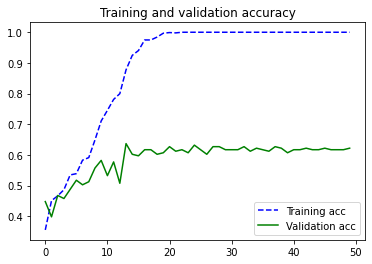

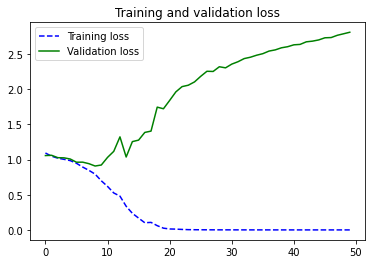

Matrice de confusion
NY :   TP: 31  FN: 36  FP: 20
Paris :   TP: 42  FN: 19  FP: 31
Tokyo :   TP: 55  FN: 18  FP: 22
La précision globale est de 0.6%

------------------------------------------
| Classe | Précision | Rappel | F1-score |
------------------------------------------
| NY     |   0.61    |  0.46  |   0.53   |
------------------------------------------
| Paris  |   0.58    |  0.69  |   0.63   |
------------------------------------------
| Tokyo  |   0.71    |  0.75  |   0.73   |
------------------------------------------


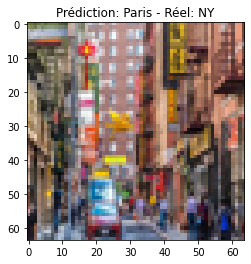

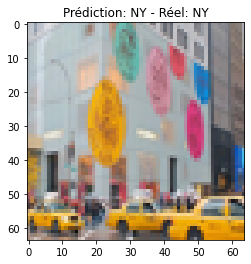

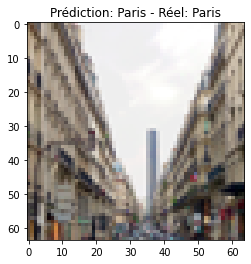

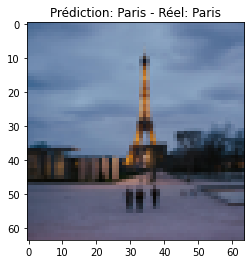

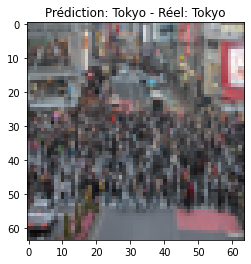

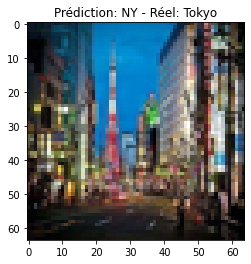

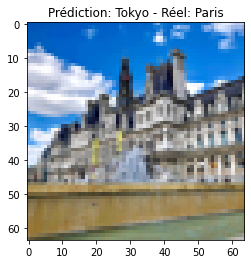

In [54]:
# Analyse des résultats
plot_training_analysis(history_bm1, 'accuracy')

show_analye(x_test, y_test, model)

### VGG-16

#### Transfer learning

In [68]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [69]:
train_features = conv_base.predict(x_train)
train_features = np.reshape(train_features,(train_features.shape[0],2*2*512))

val_features = conv_base.predict(x_val)
val_features = np.reshape(val_features,(val_features.shape[0],2*2*512))

In [70]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers

model = Sequential()

model.add(Dense(256, activation='relu', input_dim=2*2*512))
model.add(Dense(len(CLASSES), activation="softmax"))


model.compile(optimizer=optimizers.Adam(learning_rate=3e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()


history = model.fit(train_features, y_train,
                    epochs=EPOCHS,
                    batch_size=16,
                    validation_data=(val_features, y_val))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 525,315
Trainable params: 525,315
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
60/60 [==============================] - 1s 5ms/step - loss: 0.9848 - accuracy: 0.5105 - val_loss: 0.8466 - val_accuracy: 0.6219
Epoch 2/50
60/60 [==============================] - 0s 4ms/step - loss: 0.7698 - accuracy: 0.6688 - val_loss: 0.8080 - val_accuracy: 0.6468
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.7526 - val_loss: 0.7839 - val_accuracy: 0.6567
Epoch 4/50
60/60 [======

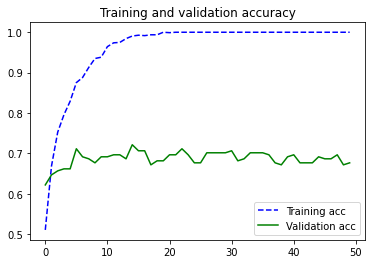

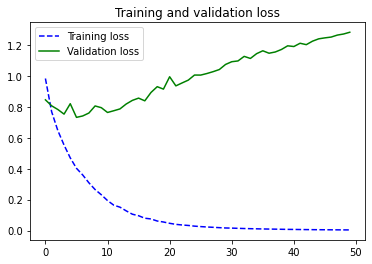

In [71]:
plot_training_analysis(history, 'accuracy')

#### Intégration de l'augmentation de données

In [72]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(Dense(256, activation='relu', input_dim=2*2*512))
model.add(Dense(len(CLASSES), activation="softmax"))


conv_base.trainable = False
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                                 
 dense_11 (Dense)            (None, 3)                 771       
                                                                 
Total params: 15,240,003
Trainable params: 525,315
Non-trainable params: 14,714,688
_________________________________________________________________


In [73]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10), 
                    validation_data=(x_val, y_val),
                    epochs=EPOCHS,
                    )

#Problème pas assez d'époque (10 -> 50) et on avait mis metrics=['accurency']

Epoch 1/50
96/96 [==============================] - 11s 114ms/step - loss: 1.0014 - sparse_categorical_accuracy: 0.4979 - val_loss: 0.9921 - val_sparse_categorical_accuracy: 0.4577
Epoch 2/50
96/96 [==============================] - 11s 113ms/step - loss: 0.8483 - sparse_categorical_accuracy: 0.6048 - val_loss: 0.8729 - val_sparse_categorical_accuracy: 0.6119
Epoch 3/50
96/96 [==============================] - 11s 113ms/step - loss: 0.7885 - sparse_categorical_accuracy: 0.6530 - val_loss: 0.8134 - val_sparse_categorical_accuracy: 0.6418
Epoch 4/50
96/96 [==============================] - 11s 113ms/step - loss: 0.7309 - sparse_categorical_accuracy: 0.6834 - val_loss: 0.8576 - val_sparse_categorical_accuracy: 0.6269
Epoch 5/50
96/96 [==============================] - 11s 114ms/step - loss: 0.7320 - sparse_categorical_accuracy: 0.6824 - val_loss: 0.8014 - val_sparse_categorical_accuracy: 0.6418
Epoch 6/50
96/96 [==============================] - 12s 125ms/step - loss: 0.6658 - sparse_cate

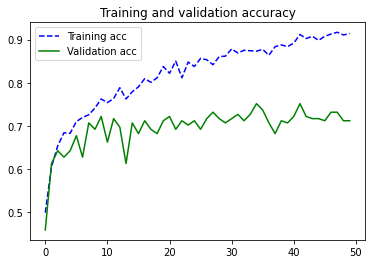

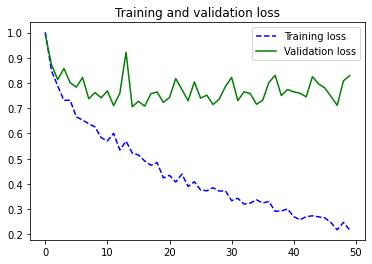

Matrice de confusion
NY :   TP: 44  FN: 23  FP: 20
Paris :   TP: 46  FN: 15  FP: 17
Tokyo :   TP: 55  FN: 18  FP: 19
La précision globale est de 0.7%

------------------------------------------
| Classe | Précision | Rappel | F1-score |
------------------------------------------
| NY     |   0.69    |  0.66  |   0.67   |
------------------------------------------
| Paris  |   0.73    |  0.75  |   0.74   |
------------------------------------------
| Tokyo  |   0.74    |  0.75  |   0.75   |
------------------------------------------


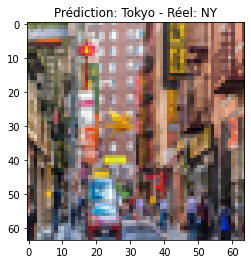

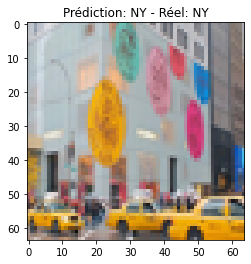

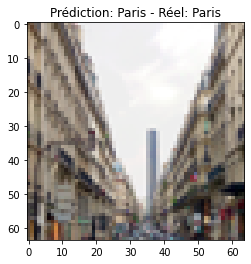

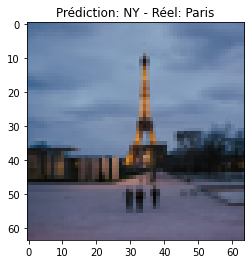

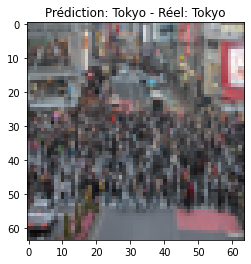

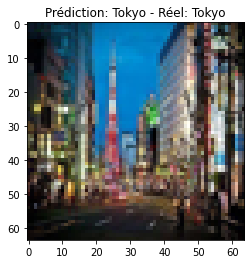

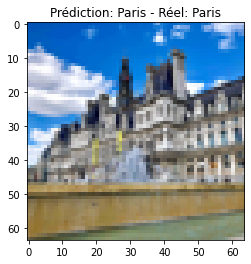

In [74]:
plot_training_analysis(history, 'sparse_categorical_accuracy')

show_analye(x_test, y_test, model)

#### Fine-tuning

In [75]:
conv_base.trainable = True
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                                 
 dense_11 (Dense)            (None, 3)                 771       
                                                                 
Total params: 15,240,003
Trainable params: 15,240,003
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10), 
                    validation_data=(x_val, y_val),
                    epochs=EPOCHS,
                    )

Epoch 1/50
96/96 [==============================] - 49s 506ms/step - loss: 1.3974 - sparse_categorical_accuracy: 0.3459 - val_loss: 1.1087 - val_sparse_categorical_accuracy: 0.2886
Epoch 2/50
96/96 [==============================] - 48s 501ms/step - loss: 1.1204 - sparse_categorical_accuracy: 0.3417 - val_loss: 1.0952 - val_sparse_categorical_accuracy: 0.3333
Epoch 3/50
96/96 [==============================] - 48s 502ms/step - loss: 1.1064 - sparse_categorical_accuracy: 0.3270 - val_loss: 1.0842 - val_sparse_categorical_accuracy: 0.4428
Epoch 4/50
96/96 [==============================] - 48s 502ms/step - loss: 1.1173 - sparse_categorical_accuracy: 0.3354 - val_loss: 1.0969 - val_sparse_categorical_accuracy: 0.3085
Epoch 5/50
96/96 [==============================] - 48s 502ms/step - loss: 1.1044 - sparse_categorical_accuracy: 0.3260 - val_loss: 1.0919 - val_sparse_categorical_accuracy: 0.3333
Epoch 6/50
96/96 [==============================] - 48s 503ms/step - loss: 1.0939 - sparse_cate

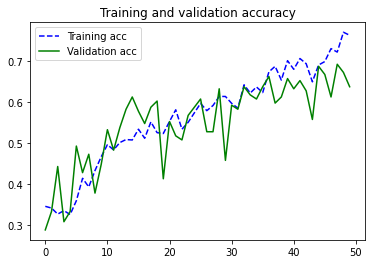

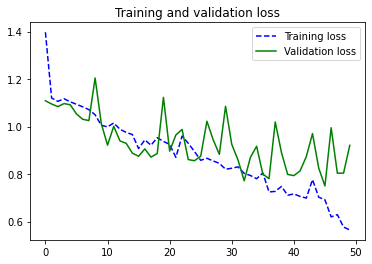

Matrice de confusion
NY :   TP: 30  FN: 37  FP: 16
Paris :   TP: 40  FN: 21  FP: 11
Tokyo :   TP: 65  FN: 8  FP: 39
La précision globale est de 0.7%

------------------------------------------
| Classe | Précision | Rappel | F1-score |
------------------------------------------
| NY     |   0.65    |  0.45  |   0.53   |
------------------------------------------
| Paris  |   0.78    |  0.66  |   0.71   |
------------------------------------------
| Tokyo  |   0.62    |  0.89  |   0.73   |
------------------------------------------


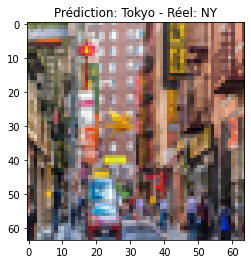

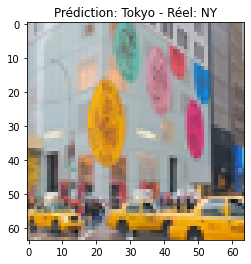

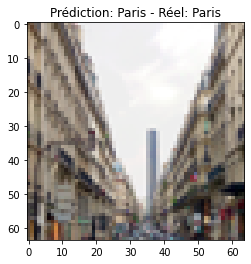

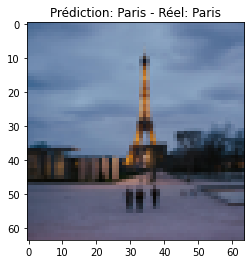

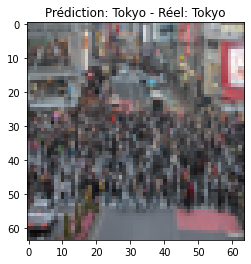

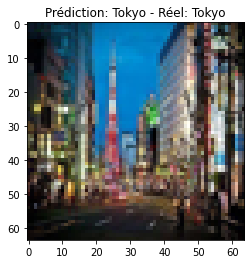

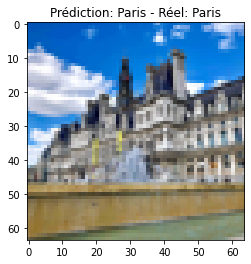

In [77]:
plot_training_analysis(history, 'sparse_categorical_accuracy')

show_analye(x_test, y_test, model)

## Analyse

Les analyses sont après chaque réseau où on affiche la précision, la perte, la matrice de confusion, et d'autres données.